In [43]:
import pandas as pd
import numpy as np
import os 
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [44]:
df = pd.read_csv("train_df_features.csv")


In [45]:
print(df.head())


              row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000091_000000        Target  SEQ_000091                 0  SUBJ_032233   
1  SEQ_000091_000001        Target  SEQ_000091                 1  SUBJ_032233   
2  SEQ_000091_000002        Target  SEQ_000091                 2  SUBJ_032233   
3  SEQ_000091_000003        Target  SEQ_000091                 3  SUBJ_032233   
4  SEQ_000091_000004        Target  SEQ_000091                 4  SUBJ_032233   

       orientation                       behavior       phase  \
0  Seated Straight  Moves hand to target location  Transition   
1  Seated Straight  Moves hand to target location  Transition   
2  Seated Straight  Moves hand to target location  Transition   
3  Seated Straight  Moves hand to target location  Transition   
4  Seated Straight  Moves hand to target location  Transition   

                 gesture     acc_x  ...  tof_5_mean  tof_5_std  tof_5_min  \
0  Above ear - pull hair -4.492188  ...      

In [46]:

rows_thm = [column for column in df.columns if column.startswith("thm_")]
print(df[rows_thm])


            thm_1      thm_2      thm_3      thm_4      thm_5
0       23.961756  23.814337  24.226456  24.972145  24.151730
1       23.901178  23.906971  23.996599  24.891283  24.180458
2       23.930208  23.978413  23.933828  24.954830  24.221441
3       23.967825  23.814337  23.936724  25.020044  24.188141
4       24.005043  23.838219  23.936348  24.911190  24.270817
...           ...        ...        ...        ...        ...
457213  29.329695  27.966221  27.857061  30.359417  29.501087
457214  29.370110  28.101042  27.965866  30.417227  29.244358
457215  29.458855  28.060148  27.893045  30.340141  29.244358
457216  29.789215  28.434057  28.046608  30.397961  28.868093
457217  29.696465  28.388973  27.965866  30.424807  28.860228

[457218 rows x 5 columns]


In [47]:
thm_Cols = df[rows_thm]

In [48]:
print(thm_Cols.values)
label_col = "sequence_type"

[[23.96175575 23.81433678 24.22645569 24.97214508 24.15172958]
 [23.90117836 23.90697098 23.9965992  24.89128304 24.18045807]
 [23.93020821 23.97841263 23.93382835 24.95483017 24.22144127]
 ...
 [29.45885468 28.06014824 27.89304543 30.3401413  29.24435806]
 [29.78921509 28.43405724 28.04660797 30.39796066 28.86809349]
 [29.69646454 28.38897324 27.96586609 30.42480659 28.86022758]]


In [49]:
X, y = [], []

for seq_id, group in df.groupby("sequence_id"):
    X.append(group[rows_thm].values)
    y.append(group[label_col].iloc[0])
    

In [50]:
max_len_sequences = int(np.percentile([len(seq) for seq in X], 95))
X_padded = pad_sequences(X, maxlen=max_len_sequences, dtype='float32', padding='post', truncating='post')

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=2)

print(f"X_pad shape: {X_padded.shape}")
print(f"y_Categorical shape: {y_categorical.shape}")

X_pad shape: (7573, 115, 5)
y_Categorical shape: (7573, 2)


In [54]:
def LSTM_RNN_THM_model(input_shape=(None, 5), num_classes=2):
    inputs = keras.layers.Input(shape = input_shape)

    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(inputs)
    x = keras.layers.Dropout(0.30)(x)
    x = keras.layers.LSTM(64)(x)
    x = keras.layers.Dropout(0.30)(x)

    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.30)(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.models.Model(inputs, outputs)

    return model
    

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_padded, y_categorical, test_size=0.20, shuffle=False
)

print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {Y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {Y_test.shape}")

X train shape: (6058, 115, 5)
Y train shape: (6058, 2)
X test shape: (1515, 115, 5)
Y test shape: (1515, 2)


In [56]:
model = LSTM_RNN_THM_model(input_shape=(max_len_sequences, len(rows_thm)))


In [57]:
optimizers = keras.optimizers.AdamW(learning_rate=1e-4, clipnorm=1.0)

model.compile(
    optimizer=optimizers,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history = model.fit(
    X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=50
)

model.summary()

Epoch 1/50


2025-10-22 10:21:16.101035: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5574 - loss: 0.7888 - val_accuracy: 0.6482 - val_loss: 0.6586
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6248 - loss: 0.7067 - val_accuracy: 0.6482 - val_loss: 0.6380
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7335 - loss: 0.5924 - val_accuracy: 0.7828 - val_loss: 0.4852
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8084 - loss: 0.4779 - val_accuracy: 0.8033 - val_loss: 0.4425
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8218 - loss: 0.4583 - val_accuracy: 0.8165 - val_loss: 0.4177
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8170 - loss: 0.4444 - val_accuracy: 0.8304 - val_loss: 0.3997
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8349 - loss: 0.4135 - val_accuracy: 0.8304 - val_loss: 0.4214
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8430 - loss: 0.3911 - val_accuracy: 0.83

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 115, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 115, 256)       │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 115, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,936 (2.61 MB)

 Trainable params: 228,226 (891.51 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 456,454 (1.74 MB)

In [58]:
train_loss , train_accuracy = model.evaluate(X_train,Y_train)
test_loss , test_accuracy = model.evaluate(X_test,Y_test)

print(f"The train accuracy {train_accuracy}")
print(f"The test accuracy {test_accuracy}")

model.save("THM_RNN_LSTM.h5")

190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8755 - loss: 0.3051
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8538 - loss: 0.3363


The train accuracy 0.8768570423126221
The test accuracy 0.8594059348106384


/tmp/ipykernel_52904/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_52904/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

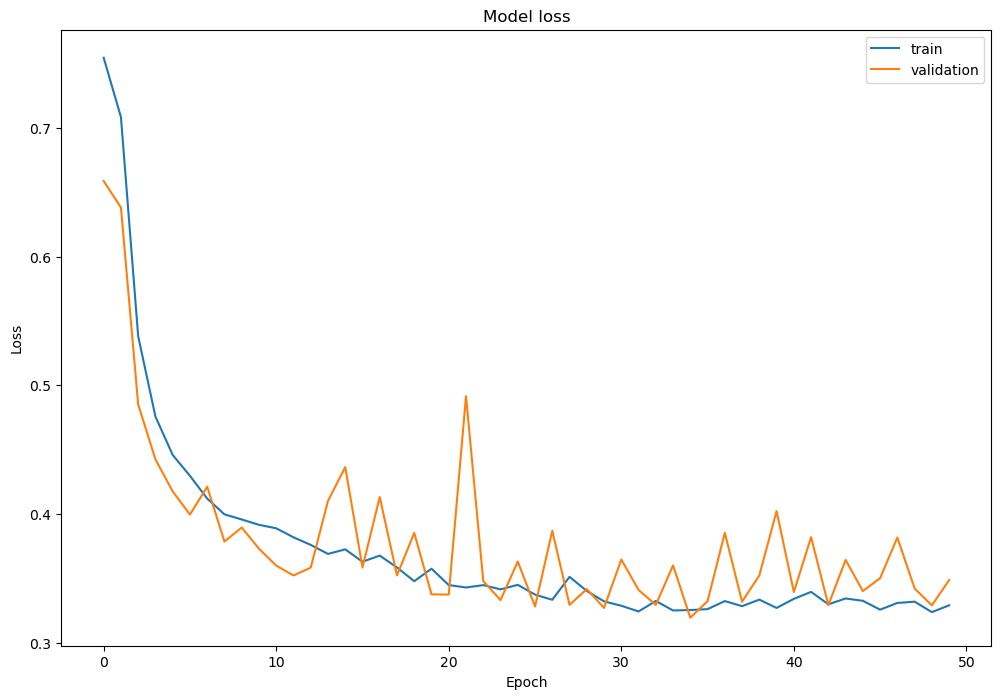

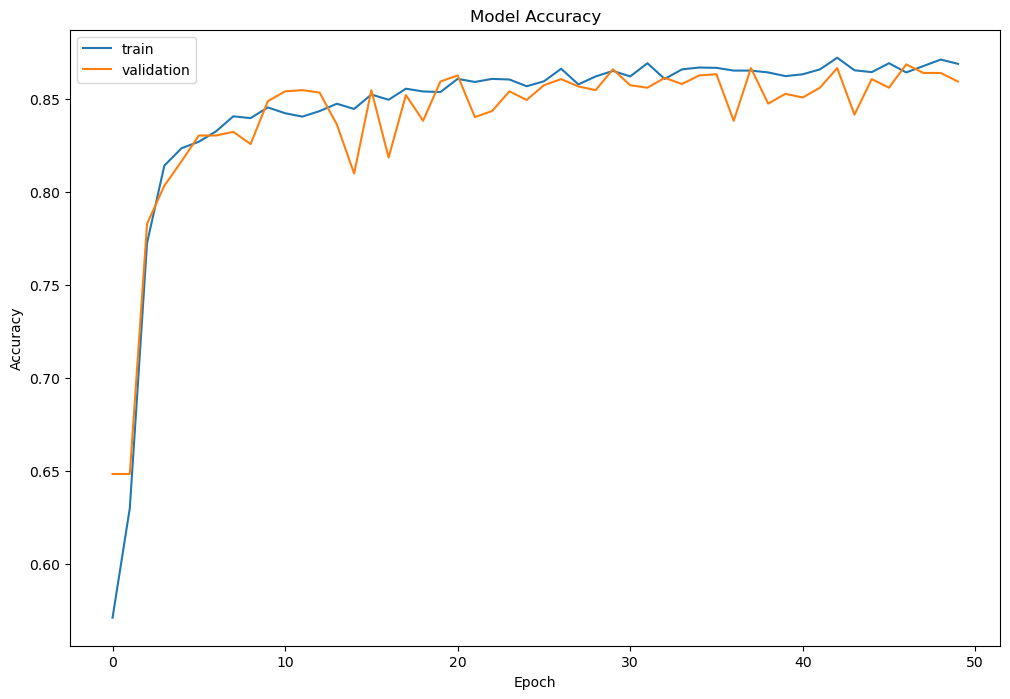

In [59]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')